<a href="https://colab.research.google.com/github/sayan0506/Tensorflow-in-practice-specialization/blob/master/RNN_model_on_synthetic_time_series_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%203%20Lesson%202%20-%20RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.0


In [ ]:
# creating the synthetic data
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

# using the simplernn layer
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  # here we pass total nodes in the RNN layer, which will berpeated based on the number of timesteps in the window
  # returned sequence = True implies, no of input = no ogf output from the sequence model layer
  # as both the RNN layers are cascaded to each other, thus we have done this
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.Adam(lr=1e-8)
                                     #, momentum=0.9)
model.compile(loss='mse',
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 2s 14ms/step - loss: 39230.8971 - mae: 195.1991
Epoch 2/100
8/8 [==============================] - 0s 13ms/step - loss: 39630.5677 - mae: 196.5054
Epoch 3/100
8/8 [==============================] - 0s 13ms/step - loss: 39649.6567 - mae: 196.4229
Epoch 4/100
8/8 [==============================] - 0s 12ms/step - loss: 39641.1315 - mae: 196.2883
Epoch 5/100
8/8 [==============================] - 0s 13ms/step - loss: 39285.3880 - mae: 195.2530
Epoch 6/100
8/8 [==============================] - 0s 12ms/step - loss: 39287.4431 - mae: 195.4383
Epoch 7/100
8/8 [==============================] - 0s 11ms/step - loss: 39306.7474 - mae: 195.6353
Epoch 8/100
8/8 [==============================] - 0s 12ms/step - loss: 39613.8841 - mae: 196.5455
Epoch 9/100
8/8 [==============================] - 0s 12ms/step - loss: 39832.0412 - mae: 197.0900
Epoch 10/100
8/8 [==============================] - 0s 12ms/step - loss: 39606.7326 - mae: 196.3921
Epoch 11/

(1e-08, 0.0001, 0.0, 1000.0)

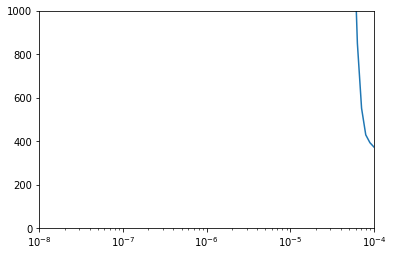

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 1000])

In [ ]:
# it's very important, as tf.keras.clear_session() clears the 
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.Adam(lr=1e-4)
                                     #, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=500)

Epoch 1/500
8/8 [==============================] - 1s 12ms/step - loss: 185.0325 - mae: 185.5325
Epoch 2/500
8/8 [==============================] - 0s 12ms/step - loss: 144.9168 - mae: 145.4168
Epoch 3/500
8/8 [==============================] - 0s 13ms/step - loss: 102.0338 - mae: 102.5335
Epoch 4/500
8/8 [==============================] - 0s 13ms/step - loss: 58.4843 - mae: 58.9837
Epoch 5/500
8/8 [==============================] - 0s 13ms/step - loss: 21.2704 - mae: 21.7675
Epoch 6/500
8/8 [==============================] - 0s 15ms/step - loss: 17.9756 - mae: 18.4702
Epoch 7/500
8/8 [==============================] - 0s 12ms/step - loss: 14.0797 - mae: 14.5697
Epoch 8/500
8/8 [==============================] - 0s 12ms/step - loss: 11.4837 - mae: 11.9765
Epoch 9/500
8/8 [==============================] - 0s 12ms/step - loss: 9.9054 - mae: 10.3882
Epoch 10/500
8/8 [==============================] - 0s 12ms/step - loss: 9.1114 - mae: 9.5987
Epoch 11/500
8/8 [============================

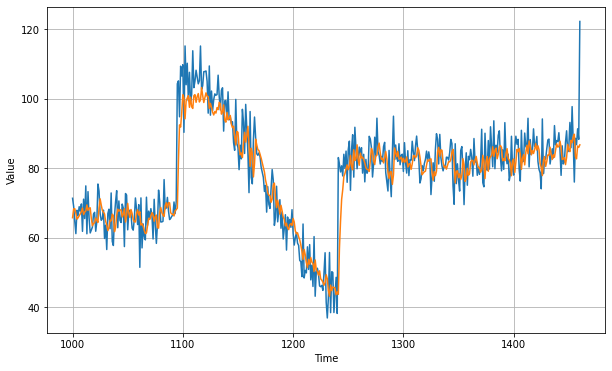

In [ ]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.0398808

<Figure size 432x288 with 0 Axes>

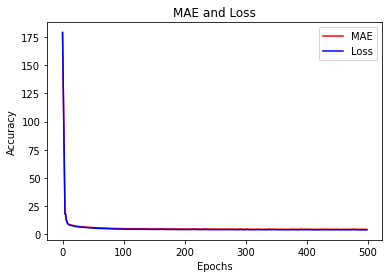

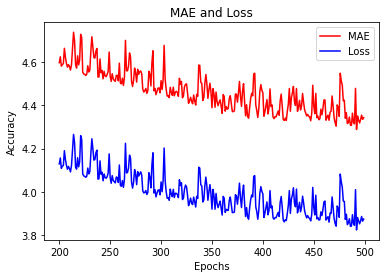

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()